In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The token can be used to access the repository
!git clone https://github.com/cariello1/BIO-NER-.git

Cloning into 'BIO-NER-'...
remote: Enumerating objects: 496, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 496 (delta 76), reused 0 (delta 0), pack-reused 365
Receiving objects: 100% (496/496), 12.49 MiB | 19.76 MiB/s, done.
Resolving deltas: 100% (262/262), done.


In [ ]:
%cd /content/BIO-NER-

/content/BIO-NER-


In [ ]:
from preprocessing_1 import PreprocessingDocsNN
from preprocessing_1 import read_data

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

# PREPROCESSING

In [ ]:
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import tensorflow

In [ ]:
# For reproducibility
seed = 937
np.random.seed(seed)
tensorflow.compat.v1.set_random_seed(seed)

In [ ]:
# Original data in IOB format
file1_train = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/train.tsv"
file2_test = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/test.tsv"
file3_dev = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/devel.tsv"

In [ ]:
input_train = read_data(file1_train)
input_test = read_data(file2_test)
input_dev = read_data(file3_dev)

Total number of sentences: 30682 
Total number of sentences: 26364 
Total number of sentences: 30639 


In [ ]:
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)
docs_dev = PreprocessingDocsNN(input_dev)

In [ ]:
# First sentence of dataset with both words and labels
print('This is what a sentence looks like:{}'.format(input_train[14]))

This is what a sentence looks like:[('Data', 'O'), ('on', 'O'), ('body', 'O'), ('weight', 'O'), (',', 'O'), ('body', 'O'), ('weight', 'O'), ('gain', 'O'), ('(', 'O'), ('BWG', 'O'), (')', 'O'), (',', 'O'), ('feed', 'O'), ('intake', 'O'), (',', 'O'), ('and', 'O'), ('feed', 'O'), ('conversion', 'O'), ('ratio', 'O'), ('(', 'O'), ('FCR', 'O'), (')', 'O'), ('were', 'O'), ('recorded', 'O'), ('at', 'O'), ('weekly', 'O'), ('intervals', 'O'), ('.', 'O')]


In [ ]:
print("\033[1m"+"Statistics for the train set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))

Statistics for the train set:
Number of sentences: 30682
Number of tokens: 891948
Size of vocabulary: 40528
Tagset: B-Chemical I-Chemical O
Number of Tags 3


In [ ]:
docs_train.data[0]

[('DPP6', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('candidate', 'O'),
 ('gene', 'O'),
 ('for', 'O'),
 ('neuroleptic', 'O'),
 ('-', 'O'),
 ('induced', 'O'),
 ('tardive', 'O'),
 ('dyskinesia', 'O'),
 ('.', 'O')]

In [ ]:
count = 0
for s in docs_train.data:
  for w, l in s:
   if w.startswith("B"):
      count= count+1
ent = []

In [ ]:
print(count)

3510


In [ ]:
lista = []
for x in docs_test.data:
  for (w,l) in x:
    if l.startswith("B-"):
      lista.append(w)



In [ ]:
len(docs_test.sentences)

26364

# DATA VISUALIZATION

Visualization of sentence distribution as a function of their length.

In [ ]:
sentences_len = np.array([len(s) for s in docs_train.sentences]) #list with len for each sents

In [ ]:
sen_mean = np.round(sentences_len.mean()).astype(int) 

In [ ]:
max_seq_len = 50 #timesteps

In [ ]:
sns.set_palette("Set3")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


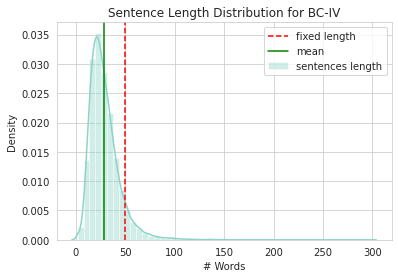

In [ ]:
sns.distplot(sentences_len, hist=True, kde=True, label="sentences length")
plt.axvline(x=max_seq_len, color="r", linestyle="--", label="fixed length")
plt.axvline(x=sen_mean, color="g", linestyle="-", label="mean")
plt.title("Sentence Length Distribution for BC-IV")
plt.xlabel("# Words")
plt.legend()
plt.show()

In [ ]:
sent_less_than_msl = [s for s in docs_train.sentences if len(s) <= 50]
perc_sent = round(len(sent_less_than_msl) / len(docs_train.sentences) * 100)
print("The", perc_sent,"%", "of sentences has less or equal than 50 tokens.")

The 92 % of sentences has less or equal than 50 tokens.


# PREPROCESSING FOR TRAINING
<p style='text-align: justify;'>Before feeding the data to the model we need to further preprocess the text. In order to feed the data to the Bi-LSTM model, we need to ensure that all text should be of the same length. The method sequence **pad_sequences()** and variable *max_seq_len* are used for this purpose. The text which are shorter than fixed *max_seq_len* value are padded to get them to the same length, whereas text which are longer than *max_seq_len* are truncated. Then, we use the **TextVectorization** layer from tf as text encoder. This allows to transforms a sequences of strings into a list of token indices. Every token in a sequence is mapped to a corresponding integer ID. This saves a lot of memory.</p>

In [ ]:
# Padding sentences to the max_seq_len
from keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(maxlen=max_seq_len, sequences=docs_train.sentences, padding="post", value="", dtype=object, truncating = "post")
X_test_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_test.sentences, padding="post", value="", dtype=object, truncating = "post")
X_dev_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_dev.sentences, padding="post", value="", dtype=object, truncating = "post")

In [ ]:
X_test_padded[812]

array(['NAAG', 'can', 'activate', 'these', 'presynaptic', 'receptors',
       'with', 'extremely', 'high', 'affinity', 'and', 'with',
       'characteristics', 'compatible', 'with', 'the', 'reported',
       'mGluR3', 'pharmacology', '.', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', ''], dtype=object)

In [ ]:
# Vocabulary Key:Tag -> Value:ID_tag & Vocabulary Key:ID_tag -> Value:Tag
tag2idx, idx2tag = docs_train.from_labels_2_idx()

In [ ]:
tag2idx

{'B-Chemical': 3, 'I-Chemical': 2, 'O': 1, 'PAD': 0}

In [ ]:
# Padding and encoding the target variable
y_train = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)
y_dev = docs_dev.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
y_train[230]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
y_train[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
# Build the text encoder layer
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(split=None, standardize = None, ngrams=None,
    max_tokens=None, output_mode = "int")

In [ ]:
# Create the vocabulary
encoder.adapt(docs_train.tokens)

In [ ]:
# Extract the vocabulary
voc = np.array(encoder.get_vocabulary())

In [ ]:
# Explore first 30 more frequent words in the train set, first entry reserved for PAD
voc[:30] 

array(['', '[UNK]', '.', ',', '-', 'of', 'the', 'and', ')', '(', 'in',
       'to', 'a', 'with', 'for', 'that', 'by', 'The', 'is', 'was', 'were',
       'as', '/', '1', '2', 'on', 'from', 'are', '3', 'an'], dtype='<U44')

In [ ]:
# A dict mapping words to their IDs
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# A dict mapping IDs to their words
idx2word = {i: w for w, i in word_index.items()}

In [ ]:
# Map padded sentences to integer IDs
X_train = encoder(np.array(X_train_padded))
X_test = encoder(np.array(X_test_padded))
X_dev = encoder(np.array(X_dev_padded))

In [ ]:
# Decoding in the test set; some words that are OOV are decoded as [UNK]
for n in range(3):
  print("Original: ", docs_test.sentences[n])
  print("Round-trip: ", " ".join(voc[X_test[n]]))
  print() 

Original:  ['Effects', 'of', 'docosahexaenoic', 'acid', 'and', 'methylmercury', 'on', 'child', "'", 's', 'brain', 'development', 'due', 'to', 'consumption', 'of', 'fish', 'by', 'Finnish', 'mother', 'during', 'pregnancy', ':', 'a', 'probabilistic', 'modeling', 'approach', '.']
Round-trip:  Effects of docosahexaenoic acid and methylmercury on child ' s brain development due to consumption of fish by [UNK] mother during pregnancy : a probabilistic modeling approach .                      

Original:  ['Fish', 'contains', 'both', 'beneficial', 'substances', 'e', '.', 'g', '.', 'docosahexaenoic', 'acids', 'but', 'also', 'harmful', 'compounds', 'e', '.', 'g', '.', 'methylmercury', '.']
Round-trip:  Fish contains both beneficial substances e . g . docosahexaenoic acids but also harmful compounds e . g . methylmercury .                             

Original:  ['Importantly', ',', 'the', 'health', 'effects', 'caused', 'by', 'these', 'two', 'substances', 'can', 'be', 'evaluated', 'in', 'one', '

In [ ]:
# Check IDs 
print("The word 'cell' is identified by the index: {}".format(word_index["cell"]))
print("The labels 'B-Chemical' is identified by the index: {}".format(tag2idx["B-Chemical"]))

The word 'cell' is identified by the index: 39
The labels 'B-Chemical' is identified by the index: 3


# IMPLEMENTING MODEL ARCHITECTURE

Model Architecture 

In [ ]:
# Hyperparams initialization
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING = 300

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional, Input
#from keras.layers import Masking

In [ ]:
# Model definition
def build_model(max_seq, opt=None):
  input = Input(shape=(max_seq_len,),dtype="int32") #timesteps
  #mask = Masking(mask_value=0)(input)
  model = Embedding(input_dim=len(word_index), output_dim=EMBEDDING,
                    input_length=max_seq_len, mask_zero=True)(input)  # 300-dim embedding
  model = Bidirectional(LSTM(units=256, return_sequences=True,
                    recurrent_dropout=0.2))(model)  
  model = Bidirectional(LSTM(units=125, return_sequences=True,
                    recurrent_dropout=0.2))(model) 
  #model = Dropout(0.4)(model)
  out = (Dense(len(tag2idx), activation="softmax"))(model)  # output
  model = Model(input, out) 
  
  if opt:
    opt = opt
  else:
    opt = Adam()
    
  model.compile(loss= "sparse_categorical_crossentropy",
                  optimizer=opt,
                  metrics=["accuracy"])
  return model

In [ ]:
# Build the model
model = build_model(max_seq_len, RMSprop())

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           12159000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 512)           1140736   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 250)           638000    
_________________________________________________________________
dense_3 (Dense)              (None, 50, 4)             1004      
Total params: 13,938,740
Trainable params: 13,938,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""#try different optimizers

for OPTIMAZER in [SGD(), Adam(), RMSprop()]:
  print()
  model.compile(optimizer=OPTIMAZER, loss= crf_losses.crf_loss, metrics=[crf_accuracies.crf_viterbi_accuracy])
  model.fit(X_train, np.array(y_train), epochs=5, batch_size=32, verbose=1, validation_data=(X_val, np.array(y_val)))
  score = model.evaluate(X_test, np.array(y_test))
  print()
  print("OPTIMEZER: ", OPTIMAZER)
  print("\nTest score ", score[0])
  print("Test accuracy: ", score[1])"""

# TRAINING

In [ ]:
#dir_output = "/content/drive/MyDrive/BIO-NER-project/double-bi-lstm_CHEMD.h5"

In [ ]:
# Early stopping stops the training process when val_loss is not improving
# ModelCkpt save only the best model (model with lowest val_loss)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_loss", patience=2)
model_save = ModelCheckpoint(dir_output, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
def ignoring_padding(y_pred,y_test):
  """This function allows to compare predicted labels with true labels discarding padding"""
  real_pred = []
  #pred = np.argmax(y_pred, -1) # Compute the label 
  y_test_nozeroes = [[l for l in s if l != 0] for s in y_test] # Delete padding label in the original sentences
  for s, s1 in zip(y_pred, y_test_nozeroes):
    s = s.tolist() 
    real_s =  s[:len(s1)] # Delete padding from the predicted sentences
    real_pred.append(real_s)
  pred_tag = [[idx2tag[i] for i in row] for row in real_pred]
  y_test_tag = [[idx2tag[i] for i in row] for row in y_test_nozeroes]
  return pred_tag, y_test_tag

In [ ]:
%%capture
# Install seqeval library for evaluation score
!pip3 install seqeval

In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

class Metrics(Callback):
    """Custom F1 metric to look after the performance on the validation set during the training"""
    def __init__(self, validation, training):   
        super(Metrics, self).__init__()
        self.validation = validation 
        self.training = training   
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.train_f1s = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = self.model.predict(self.validation[0])
        #val_predict = np.argmax(val_predict, -1)
        y_true, y_hat = ignoring_padding(val_predict, val_targ)
        val_f1 = f1_score(y_true, y_hat, scheme=IOB2, mode="strict")
        train_targ = self.training[1]   
        train_predict = self.model.predict(self.training[0])
        #train_predict = np.argmax(train_predict, -1)
        y_true_train, y_hat_train = ignoring_padding(train_predict, train_targ)
        train_f1 = f1_score(y_true_train, y_hat_train, scheme=IOB2, mode="strict")

        logs["val_f1"] = val_f1
        logs["train_f1"] = train_f1
        
        self.val_f1s.append(round(val_f1, 6))
        self.train_f1s.append(round(train_f1, 6))
         
        print(f' — val_f1: {val_f1} ')
        return

In [ ]:
# Customised callbacks
mycallbacks = [ early_stopping]

In [ ]:
%%time
# Fit network - F1-score is measured on the validation data
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_dev, y_dev), callbacks = mycallbacks )

# LEARNING CURVES

In [ ]:
#history.history

In [ ]:
history.epoch

[0, 1, 2, 3]

In [ ]:
epochs = len(history.epoch)
epochs = range(1,epochs+1)

In [ ]:
epochs

range(1, 5)

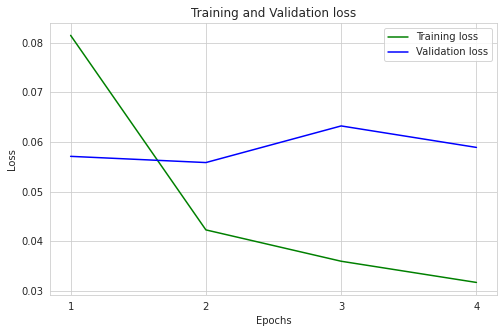

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history["loss"]
loss_val = history.history['val_loss']
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.xticks(np.arange(1, len(epochs)+1))
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

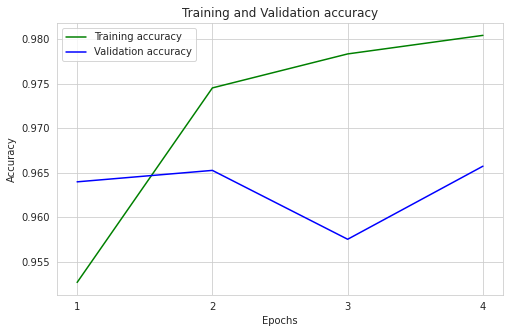

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.xticks(np.arange(1, len(epochs)+1))
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# REPORT

In [ ]:
%%capture
!pip install nervaluate

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.argmax(y_pred, -1)

In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

In [ ]:
from nervaluate import Evaluator
golden_tags = ["Chemical"]
evaluator = Evaluator(y_true, y_hat, tags = golden_tags, loader="list")
results, results_by_tag = evaluator.evaluate()
import pandas as pd
res = pd.DataFrame.from_dict(results)

In [ ]:
res

,ent_type,partial,strict,exact
correct,16423.000000,14451.000000,14451.000000,14451.000000
incorrect,0.000000,0.000000,1972.000000,1972.000000
partial,0.000000,1972.000000,0.000000,0.000000
missed,7566.000000,7566.000000,7566.000000,7566.000000
spurious,4086.000000,4086.000000,4086.000000,4086.000000
possible,23989.000000,23989.000000,23989.000000,23989.000000
actual,20509.000000,20509.000000,20509.000000,20509.000000
precision,0.800770,0.752694,0.704617,0.704617
recall,0.684605,0.643503,0.602401,0.602401
f1,0.738146,0.693829,0.649512,0.649512


In [ ]:
from seqeval.metrics import classification_report

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

Classification report for #1 model without LR optimization (exact match): 

              precision    recall  f1-score   support

    Chemical       0.73      0.61      0.66     23802

   micro avg       0.73      0.61      0.66     23802
   macro avg       0.73      0.61      0.66     23802
weighted avg       0.73      0.61      0.66     23802



In [ ]:
results_by_tag

{'Chemical': {'ent_type': {'actual': 20509,
   'correct': 16423,
   'f1': 0.7381455346307699,
   'incorrect': 0,
   'missed': 7566,
   'partial': 0,
   'possible': 23989,
   'precision': 0.8007703934857867,
   'recall': 0.6846054441619075,
   'spurious': 4086},
  'exact': {'actual': 20509,
   'correct': 14451,
   'f1': 0.6495123376331521,
   'incorrect': 1972,
   'missed': 7566,
   'partial': 0,
   'possible': 23989,
   'precision': 0.7046174850065825,
   'recall': 0.6024011005043979,
   'spurious': 4086},
  'partial': {'actual': 20509,
   'correct': 14451,
   'f1': 0.693828936131961,
   'incorrect': 0,
   'missed': 7566,
   'partial': 1972,
   'possible': 23989,
   'precision': 0.7526939392461846,
   'recall': 0.6435032723331527,
   'spurious': 4086},
  'strict': {'actual': 20509,
   'correct': 14451,
   'f1': 0.6495123376331521,
   'incorrect': 1972,
   'missed': 7566,
   'partial': 0,
   'possible': 23989,
   'precision': 0.7046174850065825,
   'recall': 0.6024011005043979,
   'spur

In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "micro",  scheme=IOB2, mode="strict")))

F1-score: 0.638


# PREDICTION AND EVALUATION

In [ ]:
model = build_model(max_seq_len, RMSprop())

In [ ]:
dir_output

In [ ]:
model.load_weights(dir_output)

In [ ]:
X_test = X_test[:120*BATCH_SIZE]
y_test = y_test[:120*BATCH_SIZE]

In [ ]:
%%time
y_pred = model.predict(X_test)

In [ ]:
y_hat, y_test_nozeroes = ignoring_padding(y_pred, y_test)

# REPORT

In [ ]:
from seqeval.metrics import classification_report

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization: ")
print('\033[0m')
print(classification_report(y_test_nozeroes, y_hat))

In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_test_nozeroes, y_hat, average = "weighted")))

In [ ]:
from seqeval.scheme import IOB2
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_test_nozeroes, y_hat, scheme=IOB2, mode="strict"))

In [ ]:
from seqeval.scheme import IOB2
print("F1-score: {:0.3}".format(f1_score(y_test_nozeroes, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

# COMPARE RESULTS

In [ ]:
i = 18
p = model.predict(X_test[i:i+BATCH_SIZE])[0] 
p = np.argmax(p, axis=-1)

In [ ]:
# From tensor to array
X_test1 = tf.make_tensor_proto(X_test)
X_test1 = tf.make_ndarray(X_test1)

In [ ]:
# Compare results
y_test1=y_test_nozeroes
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*45)
for w, true, pred in zip(X_test1[i], y_test1[i], p):
    if w != 0:
      print("{:15}:{:15} ({})".format(idx2word[w], idx2tag[pred], true))

# TUNING LEARNING RATE

LRFinder implements a Keras Callback which tracks the loss associated with a learning rate varied linearly over a defined range. Implementation by https://github.com/WittmannF

In [ ]:
from lrfinder import LRFinder

In [ ]:
"""# Get an instance of LRTest class
lr_finder = LRFinder(min_lr=1e-4, max_lr=1)

# Build the model again
model2 = build_model(max_seq_len, RMSprop())

# Perform the LR range test 
history = model2.fit(X_train, np.array(y_train), epochs=10, batch_size=32, verbose=0, callbacks=[lr_finder])"""

# TRAIN THE MODEL WITH OPTIMAL LR

To avoid overfitting, it will be choose a learning rate that is a little futher than the optimal value.

In [ ]:
"""# Build the model with the optimal lr
model3 = build_model(max_seq_len, RMSprop(lr=10**-2.4))

# Train the model
model3.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks=mycallbacks)"""

# PREDICTION AND EVALUATION 2

In [ ]:
%%time
y_pred = model.predict(X_test)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

# REPORT 2

In [ ]:
print('\033[1m' + "Classification report for #2 model with LR optimization: ")
print('\033[0m')
print(classification_report(y_test_nozeroes, y_hat))

In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_test_nozeroes, y_hat, average = "weighted")))

In [ ]:
from seqeval.scheme import IOB2
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_test_nozeroes, y_hat, scheme=IOB2, mode="strict"))

In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_test_nozeroes, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

In [ ]:
import sys

print('Saving classification report on file...')

original_stdout = sys.stdout 

with open('/content/drive/MyDrive/BiLSTM_BC4CHEMD_report.txt', 'a') as f:
  sys.stdout = f # Change the standard output to the file we created.
  print('\033[1m' + "Classification report Bi-LSTM for BC4CHEMD_dataset: ")
  print('\033[0m')
  print(classification_report(y_test_nozeroes, y_hat))
  sys.stdout = original_stdout # Reset the standard output to its original value
print("Done.")